In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy as sc
import matplotlib.lines as lines

import tqdm
import pandas as pd

import utils.model as utils
import utils.monte_carlo as mc

from utils.sinkhorn import sinkhorn

# Benchmark of W1 differentiable calculus : 

The goal of this notebook is to assess the capacity of Wasserstein GAN proxy to calculate Wasserstein 1 (or earth mover) distance on empirical sample and approximate the true distribution between the underlying distribution of sampled point. 
For that, we will rely on 1D gaussian, for which the Wasserstein 1 distance has a form with which it's possible to compute for same mean.

### Approximation of W1 :

To have Wassertein 1 distance in 1 dimension we need to compute the following integral : 
$$ W_1(\mathbb{P}_1,\mathbb{P}_2) = \int_0^1 |F_1^{-1}(u) - F_2^{-1}(u)|du$$
where $F_1, F_2$ are respectively the distribution functions of $\mathbb{P}_1$ and $\mathbb{P}_2$. Our case of study will be on normal distribution, with $F_1$ being the repartition function of a $\mathcal{N}(\beta_1, \sigma^2_1)$ and $F_2$ being the repartition function of a $\mathcal{N}(\beta_2, \sigma^2_2)$ 
In the case of gaussian, if we denote $\Phi$ the distribution function of a standard gaussian, we can denote that if we define $L: x\mapsto x\sigma + \beta$, then if $Y \sim \mathcal{N}(0,1)$, we have : $L(Y) \sim \mathcal{N}(\beta,\sigma^2)$. So if $X \sim \mathcal{N}(\beta,\sigma^2)$
\begin{align*}
\forall t \in \mathbb{R}, \mathbb{P}(X < t) &=  \mathbb{P}(L(Y) < t) \\
&=\mathbb{P}(Y < L^{-1}t)\\
&=\Phi(L^{-1}(t))
\end{align*}
Specifically this mean that $L\circ\Phi^{-1}$ is an inverse of the repartition function of $Y$. Pluging it in the integral we got for $L_1: x \mapsto x\sigma_1 + \beta_1$ and $L_2: x \mapsto x\sigma_2 + \beta_2$
\begin{align*} 
W_1(\mathbb{P}_1,\mathbb{P}_2) &= \int_0^1 |F_1^{-1}(u) - F_2^{-1}(u)|du \\
&= \int_0^1 |L_1(\Phi^{-1}(u)) - L_2(\Phi^1{-1}(u))|du \\
&= \int_0^1 |\sigma_1\Phi^{-1}(u) - \beta_1 - \sigma_2\Phi^{-1}(u) + \beta_2|du \\
&= \int_0^1 |(\sigma_1 - \sigma_2)\Phi^{-1}(u) - \beta_1 + \beta_2|du\\
\end{align*}

Specifically, this means that in the case of two normal with the same standard deviation, it's possible to calculate the distance exactly, because it's exactly the difference between the two mean. 

In [3]:
# Parameter we won't change in the rest of the notebook :
learning_rate = 5e-4

n_critic = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Neural net approximation : 

We will first try to see the performance of neural net to approximate W1 distance.
The test will be on 1D gaussian sample with same scaling as W1 distance is known in this case. 

In [4]:
# Custom sampler to sample in the GPU during the training :
sampler1 = utils.Sampler(10, 1, 64, device)
sampler2 = utils.Sampler(0, 1, 64, device)

We will make a grid of two walues to assess the performance of neural net approximation : number of sample by gradient calculus and number of gradient calculus. 

In [5]:
liste_nb_gradient = [10, 100, 500, 1000]
liste_nb_sample = [32, 64, 128, 256]

dict_result = {
    "Time taken": [],
    "Final distance": [],
}

dic_index = {"Number of gradient": [], "Number of sample": []}

dict_traj = {}

In [6]:
# Running on the grid :

for nb_gradient in liste_nb_gradient:
    for nb_sample in liste_nb_sample:
        sampler1.length_batch = nb_sample
        sampler2.length_batch = nb_sample
        model = utils.Critic()
        model.to(device)
        optimizer = torch.optim.RMSprop(
            model.parameters(), lr=learning_rate, maximize=True
        )
        histo_distance, time = utils.critic_training(
            sampler1, sampler2, model, optimizer, nb_gradient, device
        )
        dic_index["Number of gradient"].append(nb_gradient)
        dic_index["Number of sample"].append(nb_sample)
        dict_result["Time taken"].append(time)
        dict_result["Final distance"].append(histo_distance[-1])
        dict_traj[(nb_gradient, nb_sample)] = histo_distance

distance tensor(-0.2607, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 10/10 [00:01<00:00,  7.27it/s]
distance tensor(0.0211, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 10/10 [00:00<00:00, 208.83it/s]
distance tensor(0.0996, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 10/10 [00:00<00:00, 257.54it/s]
distance tensor(0.1731, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 10/10 [00:00<00:00, 268.12it/s]
distance tensor(0.0723, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 100/100 [00:00<00:00, 278.14it/s]
distance tensor(0.1644, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 100/100 [00:00<00:00, 281.47it/s]
distance tensor(-0.4957, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 100/100 [00:00<00:00, 294.84it/s]
distance tensor(-0.0525, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 100/100 [00:00<00:00, 284.04it/s]
distance tensor(0.0094, device='cuda:0', grad_fn=<NegBackward0>): 100%

In [7]:
# Table :
index = pd.MultiIndex.from_frame(pd.DataFrame(dic_index))
result = pd.DataFrame(dict_result, index=index)
result

Time taken  Final distance
Number of gradient Number of sample                            
10                 32                  1.377728        0.000130
                   64                  0.049442        0.000497
                   128                 0.040478        0.000324
                   256                 0.038669        0.000538
100                32                  0.360872        0.003157
                   64                  0.356716        0.003398
                   128                 0.340747        0.001439
                   256                 0.353899        0.001510
500                32                  1.698406        0.010424
                   64                  1.729297        0.008453
                   128                 1.701530        0.005997
                   256                 1.662915        0.004742
1000               32                  3.339610        0.007953
                   64                  3.374520        0.006502
                   128                 3.362069        0.009028
                   256                 3.289795        0.008229

One of the first interesting things to remark is that the time of training doesn't scall much with different sample size, which can be very interesting if somehow you have to deal with huge dataset or to calculate some kind of divergence over a large number of point. 

##### How fast the network converge to a seemingly stable solution ?  

On of the first question is how fast (how much iteration ?) the neural network converges to a stable solution, as it is necessary to asses the time taken by the network to estimate the distance. 

Text(0.02, 0.5, 'Distance')

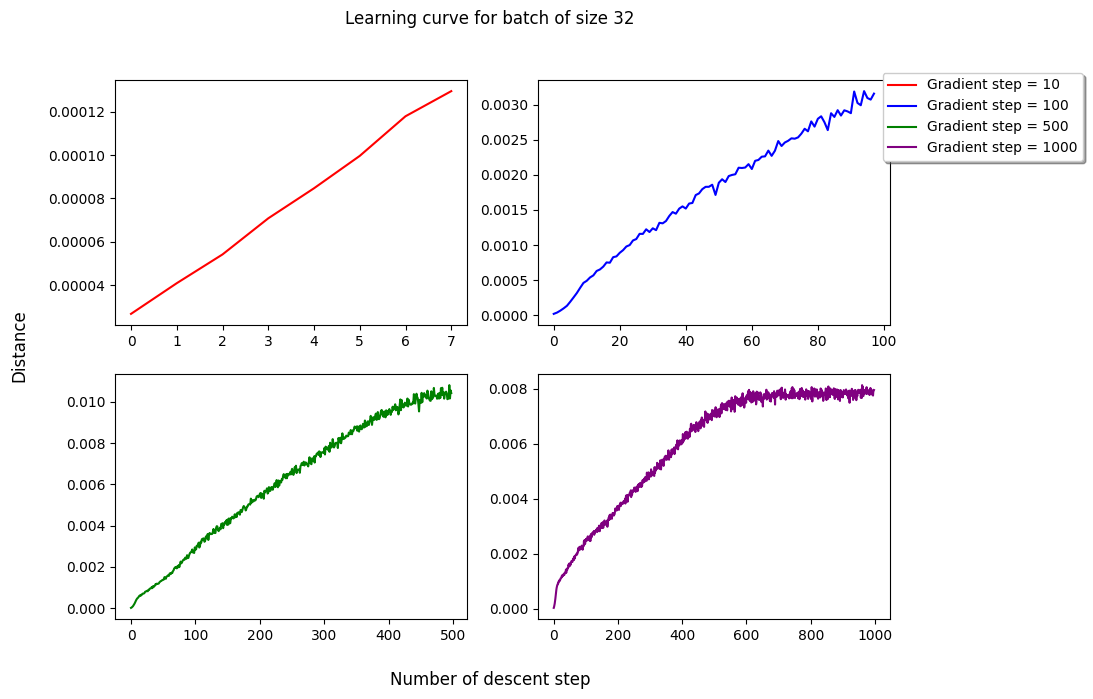

In [8]:
# We can look at different trajectory for the distance, especially to see if for biggest number of gradient calculus
# the critic is already saturated or not :

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 7))

ax1.plot(dict_traj[(10, 32)][2:], color="red")
red_line = lines.Line2D([], [], color="red", label="Gradient step = 10")

ax2.plot(dict_traj[(100, 32)][2:], color="blue")
blue_line = lines.Line2D([], [], color="blue", label="Gradient step = 100")

ax3.plot(dict_traj[(500, 32)][2:], color="green")
green_line = lines.Line2D([], [], color="green", label="Gradient step = 500")

ax4.plot(dict_traj[(1000, 32)][2:], color="purple")
purple_line = lines.Line2D([], [], color="purple", label="Gradient step = 1000")

fig.legend(
    handles=[red_line, blue_line, green_line, purple_line],
    bbox_to_anchor=(1.1, 0.9),
    ncol=1,
    fancybox=True,
    shadow=True,
)
fig.suptitle("Learning curve for batch of size 32")
fig.supxlabel("Number of descent step")
fig.supylabel("Distance")

As we can see here, the short time of training of first experience doesn't allow the distance to converge at all. Even with ten times more iteration, the network still doesn't seem to have fully converged to it's maximum. It's only at 500 iteration that we can see the distance beginning to stabilize, which is confirmed by the longer trajectory where the last four hundreds iterations clearly oscillate randomly, depending on the sampling.
But what happen with a larger batch ? 

Text(0.02, 0.5, 'Distance')

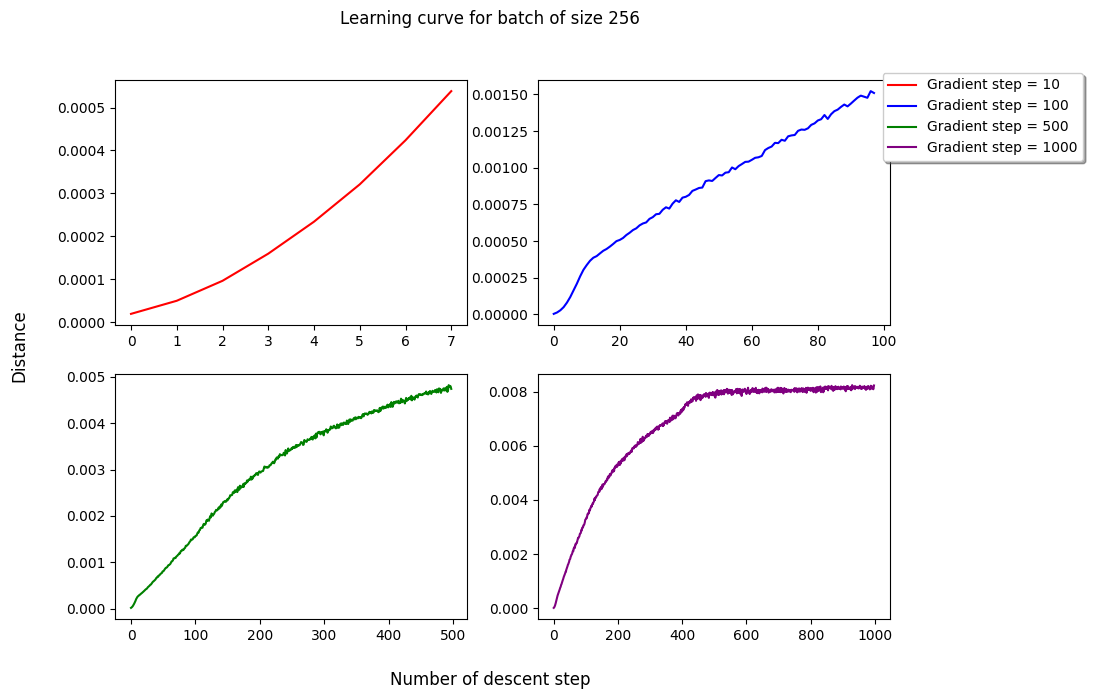

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 7))

ax1.plot(dict_traj[(10, 256)][2:], color="red")
red_line = lines.Line2D([], [], color="red", label="Gradient step = 10")

ax2.plot(dict_traj[(100, 256)][2:], color="blue")
blue_line = lines.Line2D([], [], color="blue", label="Gradient step = 100")

ax3.plot(dict_traj[(500, 256)][2:], color="green")
green_line = lines.Line2D([], [], color="green", label="Gradient step = 500")

ax4.plot(dict_traj[(1000, 256)][2:], color="purple")
purple_line = lines.Line2D([], [], color="purple", label="Gradient step = 1000")

fig.legend(
    handles=[red_line, blue_line, green_line, purple_line],
    bbox_to_anchor=(1.1, 0.9),
    ncol=1,
    fancybox=True,
    shadow=True,
)
fig.suptitle("Learning curve for batch of size 256")
fig.supxlabel("Number of descent step")
fig.supylabel("Distance")

Here, we can clearly see that the batch size, even if it smoothen the progression, doesn't seem to ameliorate the convergence rate of the neural network, as the convergence still seems to arrive after five hundreds to six hundreds iteration. 

##### Is the solution close to Wasserstein 1 distance ? 

The second question we want to answer is how close the result is from Wasserstein 1 distance ?

One of the first problem with this question is that we need to control the lipschitz constant of the neural network. This is dependant of our architecture. Here we use a 4 layer Neural Network with 64 nodes for each layer. The relu function being already 1-Lipschitz, the problem is to control the lipschitz constant of each linear function applied layer by layer. That's why we clamped the parameters in $[-1/64,1/64]$, as it allow to control the operator norm of all linear functions applied by 1, except the first and last transformation, which are 1/2 Lipschitz . Indeed as we have $$||L^Tx - L^Ty|| \geq ||L^T||~||x-y|| \geq 64/128 ||x-y|| = 1/2 ||x-y||$$ for the last layer, the computation for the first layer being really similar. The neural network being a composition of all these functions, we can deduce that the neural ntwork is $1/4$ Lipschitz, so we will need to multiply at least by 4 the result we got.

In [10]:
result["Final distance"] * 4

Number of gradient  Number of sample
10                  32                  0.000518
                    64                  0.001987
                    128                 0.001294
                    256                 0.002152
100                 32                  0.012627
                    64                  0.013593
                    128                 0.005755
                    256                 0.006040
500                 32                  0.041697
                    64                  0.033813
                    128                 0.023988
                    256                 0.018970
1000                32                  0.031811
                    64                  0.026009
                    128                 0.036111
                    256                 0.032916
Name: Final distance, dtype: float64

In [11]:
dict_traj[(1000, 256)][-10:]

[0.008170531131327152,
 0.008123785257339478,
 0.008204146288335323,
 0.008120346814393997,
 0.008154984563589096,
 0.00817015115171671,
 0.00811918918043375,
 0.008090115152299404,
 0.00816139206290245,
 0.008229104802012444]

We can see here with naked eye that the estimated distance is very far from the true value (which is 10). This can stem from two fact : eather the neural network doesn't approximate correctly the W1 distance, or our estimation of the Lipschitz constant is very far (or a factor ~ 1000) from the reality. To test the second hypotheses, we can re-iterate with other value for the gaussian mean and see if we can have a somewhat common multiplicative factor that appear : 

In [12]:
mean = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

dict_traj_mean = {}
for sample1_mean in mean:
    sampler1.mean = sample1_mean
    model = utils.Critic()
    model.to(device)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, maximize=True)
    histo_distance, time = utils.critic_training(
        sampler1, sampler2, model, optimizer, 1000, device
    )
    dict_traj_mean[sample1_mean] = np.mean(histo_distance[-300:])

distance tensor(0.0013, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 1000/1000 [00:03<00:00, 292.32it/s]
distance tensor(0.0029, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 1000/1000 [00:03<00:00, 305.69it/s]
distance tensor(0.0045, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 1000/1000 [00:03<00:00, 292.26it/s]
distance tensor(0.0036, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 1000/1000 [00:03<00:00, 296.47it/s]
distance tensor(0.0045, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 1000/1000 [00:03<00:00, 293.20it/s]
distance tensor(0.0043, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 1000/1000 [00:03<00:00, 293.88it/s]
distance tensor(0.0069, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 1000/1000 [00:03<00:00, 291.38it/s]
distance tensor(0.0084, device='cuda:0', grad_fn=<NegBackward0>): 100%|██████████| 1000/1000 [00:03<00:00, 301.41it/s]
distance tensor(0.0049, device='cuda:0', grad_fn

In [13]:
for dist in mean:
    print(
        f"for a distance of {dist}, the calculated distance is {np.round(dict_traj_mean[dist]*4,4)} the multiplicative coefficient is : {np.round(dist/(dict_traj_mean[dist]*4),2)} \n"
    )

for a distance of 1.0, the calculated distance is 0.0052 the multiplicative coefficient is : 193.74 

for a distance of 2.0, the calculated distance is 0.0118 the multiplicative coefficient is : 170.06 

for a distance of 3.0, the calculated distance is 0.0186 the multiplicative coefficient is : 161.64 

for a distance of 4.0, the calculated distance is 0.0142 the multiplicative coefficient is : 282.66 

for a distance of 5.0, the calculated distance is 0.018 the multiplicative coefficient is : 277.07 

for a distance of 6.0, the calculated distance is 0.0174 the multiplicative coefficient is : 345.73 

for a distance of 7.0, the calculated distance is 0.0276 the multiplicative coefficient is : 253.97 

for a distance of 8.0, the calculated distance is 0.0329 the multiplicative coefficient is : 243.28 

for a distance of 9.0, the calculated distance is 0.0196 the multiplicative coefficient is : 458.84 



We can see here that the coefficient is not constant at all, and even seems to grow with the distance. This tend to demonstrates that the proxy for the Wasserstein distance doesn't converge to the W1 distance in this very particular case. However, we can also see that the result are not completely far fetched and reflect somehow the W1 distance "hierarchie" for the law that are "the closest" from one another.

# Sinkhorn algorithm

## Reminder on the algorithm

In real applications, and especially in Machine Learning, we often have to deal with huge numbers of points. In this case, the linear programming algorithms which have cubic complexity will take too much time to run. That's why in practise, among other reasons, people minimize another criterion given by
$$
    \min_{P \in \mathcal{U}(a,b)} \langle C, P \rangle + \epsilon \sum_{ij} P_{ij} [ \log(P_{ij}) - 1].
$$
With $C$ the cost matrix. One can note when $\epsilon$ is sufficiently small, we can consider that a solution to the above problem (often refered to as "Entropy-regularized Optimal Transport") is a good approximation of a real optimal transport plan.

In order to solve this problem, one can remark that the optimality conditions imply that a solution $P_\epsilon^*$ necessarily is of the form $P_\epsilon^* = \text{diag}(u) \, K \, \text{diag}(v)$, where $K = \exp(-C/\epsilon)$ and $u,v$ are two non-negative vectors.

$P_\epsilon^*$ should verify the constraints, i.e. $P_\epsilon^* \in U(a,b)$, so that
$$
    P_\epsilon^* 1_m = a \text{  and  } (P_\epsilon^*)^T 1_n = b
$$
which can be rewritten as
$$
    u \odot (Kv) = a \text{  and  } v \odot (K^T u) = b
$$

Then Sinkhorn's algorithm alternate between the resolution of these two equations, and reads at iteration $t$:
$$
    u^{t+1} \leftarrow \frac{a}{Kv^t} \text{  and  } v^{t+1} \leftarrow \frac{b}{K^T u^{t+1}}
$$

We start from $v^{0} = \mathrm{1}_m$ and update the vector until $\|u^{t+1} \odot (Kv^{t+1}) - a\|_1 + \|v^{t+1} \odot (K^T u^{t+1}) - b\|_1 \leq \tau$, where $\tau > 0$ is a fixed convergence threshold. From an entropic optimal transport plan $P^*_\epsilon$, we can approximate the optimal transport cost by $\sum_{i,j=1}^n P^*_{\epsilon_{ij}} C_{ij} = ⟨C, P^*_\epsilon⟩$.

Hereafter, we set $\tau = 1e-4$. 

In [15]:
first_distribution = sc.stats.norm()
second_distribution = sc.stats.norm(loc=1)

nb_samples = 1000
eps = 1e-1
tau = 1e-2
nb_steps = 0

### Time taken

One important point to consider when running the Sinkhorn algorithm is the time taken before the algorithm converges. We can see that when the number of sample increases, the algorithm runs slower. It is expected because $K = exp(-D/\varepsilon)$ grows in size and the matrix multiplication takes more time.

We generate 100 times $nb\_sample$ and applicate Sinkhorn algorithm to have a relevant time per step, $nb\_step$ is then the mean of the generations.
| nb_sample | nb_step | time per step |
| :---: | :---: | :---: |
| 1000 | 7.04 | 4.83e-3  |
| 500 | 7.04 | 2.88e-3  |
| 250 | 6.80 | 1.91e-3  |
| 100 | 7.44 | 0.58e-3  |
| 10 | 7.04 | 0.28e-3 |

We take $\varepsilon = 0.2$ here and we can see that when increasing $nb\_sample$, the time per step also increases as expected. The number of steps needed also decreases for low values of $\varepsilon$, this is expected as the bigger the sample, the more information we have. This can be confirmed by these 2 tabulars.
<table>
<tr><th> nb_sample = 10 </th><th> nb_sample = 100</th></tr>
<tr><td>

| $\varepsilon$ | nb_step |
| :---: | :---: | 
| 0.1 | 78.034 |
| 0.2 | 20.810 |
| 0.3 | 12.185 |
| 0.4 | 8.998 |
| 0.5 | 7.217 |
| 0.6 | 6.232 |
| 0.7 | 5.553 |
| 0.8 | 4.919 |
| 0.9 | 4.498 |
| 1.0 | 4.136 |

</td><td>

| $\varepsilon$ | nb_step |
| :---: | :---: | 
| 0.1 | 22.6 |
| 0.2 | 13.6 |
| 0.3 | 10.1 |
| 0.4 | 8.25 |
| 0.5 | 6.99|
| 0.6 | 6.26 |
| 0.7 | 5.58 |
| 0.8 | 5.04 |
| 0.9 | 4.65 |
| 1.0 | 4.42 |
</td></tr> </table>

We can also observe the influence of $\varepsilon = \frac{1}{n^2} \sum\limits_{i, j = 1}^n D_{ij}$ with $D = D_{ij}$ the cost matrix. The greater the value of $\varepsilon$ is, the faster it converges. It is expected as $\varepsilon$ grows, the further we are away from the original problem to optimize.

In [16]:
list_sample = [1000, 500, 250, 100, 10]
list_eps = [0.2]
list_tau = [1e-4]
dict_step = dict()

repeat = 50
for nb_samples in list_sample:
    for eps in list_eps:
        for tau in list_tau:
            nb_step, value, time = sinkhorn(
                first_distribution=first_distribution,
                second_distribution=second_distribution,
                nb_samples=nb_samples,
                eps=eps,
                tau=tau,
                nb_steps=0,
            )
            dict_step[nb_samples, eps, tau] = nb_step, time / nb_step, value

df = pd.Series(dict_step).reset_index()
df.columns = ["nb_sample", "eps", "tau", "nb_step"]
df["time per step"] = df["nb_step"].str[1]
df["sinkhorn value"] = df["nb_step"].str[2]
df["nb_step"] = df["nb_step"].str[0]

for _ in range(repeat - 1):
    for nb_samples in list_sample:
        for eps in list_eps:
            for tau in list_tau:
                nb_step, value, time = sinkhorn(
                    first_distribution=first_distribution,
                    second_distribution=second_distribution,
                    nb_samples=nb_samples,
                    eps=eps,
                    tau=tau,
                    nb_steps=0,
                )
                dict_step[nb_samples, eps, tau] = nb_step, time / nb_step, value

    df_t = pd.Series(dict_step).reset_index()
    df_t.columns = ["nb_sample", "eps", "tau", "nb_step"]
    df_t["time per step"] = df_t["nb_step"].str[1]
    df_t["sinkhorn value"] = df_t["nb_step"].str[2]
    df_t["nb_step"] = df_t["nb_step"].str[0]
    df += df_t

df / repeat

,nb_sample,eps,tau,nb_step,time per step,sinkhorn value
0,1000.0,0.2,0.0001,11.86,0.000354,1.0
1,500.0,0.2,0.0001,12.12,0.000208,1.0
2,250.0,0.2,0.0001,12.60,0.000151,1.0
3,100.0,0.2,0.0001,12.82,0.000337,1.0
4,10.0,0.2,0.0001,20.12,0.000026,1.0


In [17]:
list_sample = [10]
list_eps = [i / 10 for i in range(1, 11)]
list_tau = [1e-4]
dict_step = dict()

repeat = 25
for nb_samples in list_sample:
    for eps in list_eps:
        for tau in list_tau:
            nb_step, value, time = sinkhorn(
                first_distribution=first_distribution,
                second_distribution=second_distribution,
                nb_samples=nb_samples,
                eps=eps,
                tau=tau,
                nb_steps=0,
            )
            dict_step[nb_samples, eps, tau] = nb_step, time / nb_step, value

df = pd.Series(dict_step).reset_index()
df.columns = ["nb_sample", "eps", "tau", "nb_step"]
df["time per step"] = df["nb_step"].str[1]
df["sinkhorn value"] = df["nb_step"].str[2]
df["nb_step"] = df["nb_step"].str[0]

for _ in range(repeat - 1):
    for nb_samples in list_sample:
        for eps in list_eps:
            for tau in list_tau:
                nb_step, value, time = sinkhorn(
                    first_distribution=first_distribution,
                    second_distribution=second_distribution,
                    nb_samples=nb_samples,
                    eps=eps,
                    tau=tau,
                    nb_steps=0,
                )
                dict_step[nb_samples, eps, tau] = nb_step, time / nb_step, value

    df_t = pd.Series(dict_step).reset_index()
    df_t.columns = ["nb_sample", "eps", "tau", "nb_step"]
    df_t["time per step"] = df_t["nb_step"].str[1]
    df_t["sinkhorn value"] = df_t["nb_step"].str[2]
    df_t["nb_step"] = df_t["nb_step"].str[0]
    df += df_t

df / repeat

,nb_sample,eps,tau,nb_step,time per step,sinkhorn value
0,10.0,0.1,0.0001,77.84,0.000031,1.0
1,10.0,0.2,0.0001,17.68,0.000027,1.0
2,10.0,0.3,0.0001,12.44,0.000027,1.0
3,10.0,0.4,0.0001,8.88,0.000028,1.0
4,10.0,0.5,0.0001,6.80,0.000031,1.0
5,10.0,0.6,0.0001,6.28,0.000031,1.0
6,10.0,0.7,0.0001,6.16,0.000029,1.0
7,10.0,0.8,0.0001,5.20,0.000032,1.0
8,10.0,0.9,0.0001,4.48,0.000032,1.0
9,10.0,1.0,0.0001,4.00,0.000030,1.0


In [19]:
list_sample = [100]
list_eps = [i / 10 for i in range(1, 11)]
list_tau = [1e-4]
dict_step = dict()

repeat = 100
for nb_samples in list_sample:
    for eps in list_eps:
        for tau in list_tau:
            nb_step, value, time = sinkhorn(
                first_distribution=first_distribution,
                second_distribution=second_distribution,
                nb_samples=nb_samples,
                eps=eps,
                tau=tau,
                nb_steps=0,
            )
            dict_step[nb_samples, eps, tau] = nb_step, time / nb_step, value

df = pd.Series(dict_step).reset_index()
df.columns = ["nb_sample", "eps", "tau", "nb_step"]
df["time per step"] = df["nb_step"].str[1]
df["sinkhorn value"] = df["nb_step"].str[2]
df["nb_step"] = df["nb_step"].str[0]

for _ in range(repeat - 1):
    for nb_samples in list_sample:
        for eps in list_eps:
            for tau in list_tau:
                nb_step, value, time = sinkhorn(
                    first_distribution=first_distribution,
                    second_distribution=second_distribution,
                    nb_samples=nb_samples,
                    eps=eps,
                    tau=tau,
                    nb_steps=0,
                )
                dict_step[nb_samples, eps, tau] = nb_step, time / nb_step, value

    df_t = pd.Series(dict_step).reset_index()
    df_t.columns = ["nb_sample", "eps", "tau", "nb_step"]
    df_t["time per step"] = df_t["nb_step"].str[1]
    df_t["sinkhorn value"] = df_t["nb_step"].str[2]
    df_t["nb_step"] = df_t["nb_step"].str[0]
    df += df_t

df / repeat

,nb_sample,eps,tau,nb_step,time per step,sinkhorn value
0,100.0,0.1,0.0001,23.86,0.000043,1.0
1,100.0,0.2,0.0001,13.44,0.000042,1.0
2,100.0,0.3,0.0001,10.16,0.000043,1.0
3,100.0,0.4,0.0001,8.43,0.000044,1.0
4,100.0,0.5,0.0001,7.16,0.000044,1.0
5,100.0,0.6,0.0001,6.21,0.000044,1.0
6,100.0,0.7,0.0001,5.57,0.000045,1.0
7,100.0,0.8,0.0001,5.04,0.000048,1.0
8,100.0,0.9,0.0001,4.66,0.000046,1.0
9,100.0,1.0,0.0001,4.39,0.000046,1.0


# Conclusion :

The proxy given in the Wasserstein Gan paper doesn't seem to approximate the Wassestein 1 distance, or at least not in the particular case in which we studied it. Contrary to it, Sinkhorn is a very fast and not bad estimation for W1 distance. However, the time of execution grow very fast as the size of the sample of point grow, which makes it slow quite fast. Contrary to it, the proxy seem more scalable in term of sample size. 
Moreover, the proxy for neural network seems to be pertinent at low-distances, conserving a sense of "hierarchie" close to the one of W1 distance, which may explain its relevance in the case of generative adversarial network.  
